In [1]:
#####
# Packages
##### 

import numpy as np
import pandas as pd 
import tensorflow as tf
from tensorflow import keras

/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/tensorflow_1_14/lib/python3.6/site-pack

In [2]:
print(tf.__version__)

1.14.0


## Goal of this notebook:
* Remove N/A, stop words, punctuation, lower case everything in paragraph + summary 
* Determine appropriate length of sequences for padding 
* Build the datasets for a train+cv vs. test 

## I. Read in dataset 

In [3]:
sepdata = pd.read_csv('wikihowSep.csv')

### Examine for NAs 

In [4]:
sepdata.head(5)
# Notice how we have 4 columns: 
# 'overview': the full summary based on the wikihow article 
# 'headline': the "summary" for the paragraph in 'text' column 
# 'text': the actual text of the paragraph 
# 'sectionLabel': section label of the paragraph 
# 'title': the title of which the paragraph belongs to. 

# wikihowSep (downloaded here: https://github.com/mahnazkoupaee/WikiHow-Dataset) is the same file as 
# wikihowAll, except separated by paragraph. 

# Given the length of the documents under wikihowAll, we opted for a shorter summary model to work with where we can 
# take paragraphs, and attempt to generate the headline for the paragraph instead. 

,overview,headline,text,sectionLabel,title
0,So you're a new or aspiring artist and your c...,\nSell yourself first.,"Before doing anything else, stop and sum up y...",Steps,How to Sell Fine Art Online
1,"If you want to be well-read, then, in the wor...",\nRead the classics before 1600.,Reading the classics is the very first thing ...,Reading the Classics,How to Be Well Read
2,So you're a new or aspiring artist and your c...,\nJoin online artist communities.,Depending on what scale you intend to sell yo...,Steps,How to Sell Fine Art Online
3,So you're a new or aspiring artist and your c...,\nMake yourself public.,Get yourself out there as best as you can by ...,Steps,How to Sell Fine Art Online
4,So you're a new or aspiring artist and your c...,\nBlog about your artwork.,"Given the hundreds of free blogging websites,...",Steps,How to Sell Fine Art Online


In [5]:
# Exploratory part first: 

# How many titles are there: 
len(sepdata['title'].unique()) 

214614

In [6]:
# Full dataset: how many labelled paragraphs do we have? 
len(sepdata)

1585695

In [35]:
# are there any NA's that we should drop? 
# Note here that we are only concerned about the 3 columns: headline, text, and title 

sepdata_v1 = sepdata.dropna(subset=['headline','text','title'], axis=0).reset_index(drop=True) 
len(sepdata_v1) #yes, we see some NA rows 

1387289

In [36]:
# Therefore, how many true titles do we have? 
len(sepdata_v1['title'].unique()) #only 211,825 

211825

In [37]:
# It doesn't quite matter for us since we are trying to predict headline and not the title, 
# but out of curiosity, how many paragraphs on average belong to each title? 
np.nanmean(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values) 
# Roughly 6-7 paragraphs per title 

6.5492222353357725

Text(0.5, 1.0, 'Paragraphs per Article (title)')

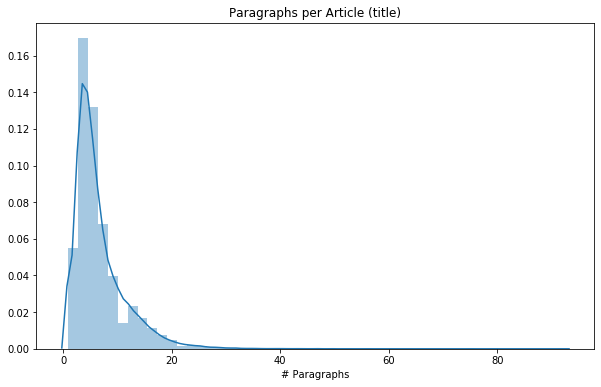

In [38]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt 

fig, axes = plt.subplots(1,1, figsize = (10,6)) 
sns.distplot(sepdata_v1[['title','text']].groupby('title').agg('count')['text'].values, 
            ax=axes, axlabel = '# Paragraphs').set_title('Paragraphs per Article (title)')
# majority of our paragarphsgenerally 

## II. Begin cleaning text of paragraphs 

In [ ]:
# Define a text cleaner 
# Drawn heavily with reference from here 
# https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [40]:
import re #for regex search purposes          
from nltk.corpus import stopwords #stopwords that are provided to us via nltk 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import math

In [41]:
# List of contractions that we will map to 

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [43]:
sepdata_v1['text'].loc[:10].values

array([" Before doing anything else, stop and sum up yourself as an artist. Now, think about how to translate that to an online profile. Be it the few words, Twitter allows you or an entire page of indulgence that your own website would allow you. Bring out the most salient features of your creativity, your experience, your passion, and your reasons for painting. Make it clear to readers why you are an artist who loves art, produces high quality art, and is a true champion of art. If you're not great with words, find a friend who can help you with this really important aspect of selling online – the establishment of your credibility and reliability.;\n",
       ' Reading the classics is the very first thing you have to do to be well-read. If you want to build a solid foundation for your understanding of the books you read, then you can\'t avoid some of the earliest plays, poems, and oral tales ever written down. Remember that the novel didn\'t really get popular until the 18th century,

In [44]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    # Step 1: Lower case the text 
    newString = text.lower()
    # Step 2: Get rid of commas
    newString = re.sub(r'\([^)]*\)', '', newString)
    # Step 3: Get rid of quotations 
    newString = re.sub('"','', newString)
    # Step 4: get rid of contractions with our contraction mapping 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])  
    # Step 5: get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 6: anything that is a number, get rid of it 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    # Step 7: Tokenize everything first and keep the words that are not stop words 
    # Also keep only words that are greater than or equal to 3 characters long 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3: #removing short words
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [46]:
cleaned_text = []
index_blah = list(range(0,len(sepdata_v1)))
for i in index_blah: 
    cleaned_text.append(text_cleaner(sepdata_v1.loc[i,'text']))

In [47]:
cleaned_text[0:10]

['anything else stop sum artist think translate online profile words twitter allows entire page indulgence website would allow bring salient features creativity experience passion reasons painting make clear readers artist loves art produces high quality art true champion art great words find friend help really important aspect selling online establishment credibility reliability',
 'reading classics first thing well read want build solid foundation understanding books read cannot avoid earliest plays poems oral tales ever written remember novel really get popular century find novels list without reading poetry homer plays sophocles able call well read list get started epic gilgamesh iliad odyssey homer oresteia aeschylus oedipus king sophocles medea euripides aeneid virgil one thousand one nights beowulf tale genji murasaki shikibu divine comedy dante decameron boccaccio canterbury tales chaucer',
 'depending scale intend sell art pieces may want get account online art community store

In [49]:
sepdata_v1['headline'][0:10]

0                               \nSell yourself first.
1                     \nRead the classics before 1600.
2                    \nJoin online artist communities.
3                              \nMake yourself public.
4                           \nBlog about your artwork.
5                             \nCreate a mailing list.
6                                \nTake good pictures.
7              \nBe sure to properly license your art.
8     \nConsider the option of creating your own site.
9    \nExpect this to be a gradual process and don'...
Name: headline, dtype: object

In [81]:
# repeat the same step for the headlines, but with some variation on cleaning 

def headline_cleaner(text):
    # Step 1: remove quotations 
    newString = re.sub('"','', text)
    # Step 2: look up contractions 
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")]) 
    # Step 3: Get rid of the \n stuff 
    newString = re.sub(r"'s\n","",newString)
    # Step 4: Get rid of numbers or anything not in the alphabet
    newString = re.sub("[^a-zA-Z]", " ", newString)
    # Step 5: Lower case 
    newString = newString.lower()
    tokens=newString.split()
    # Step 6: keep words that are greater than 1 character long 
    remaining=[]
    for i in tokens:
        if len(i)>1:                                 
            remaining.append(i) 
    return (" ".join(remaining)).strip()

In [82]:
cleaned_headline = []
index_blah = list(range(0,len(sepdata_v1)))
for i in index_blah: 
    cleaned_headline.append(headline_cleaner(sepdata_v1.loc[i,'headline']))

In [83]:
cleaned_headline[:10]

['sell yourself first',
 'read the classics before',
 'join online artist communities',
 'make yourself public',
 'blog about your artwork',
 'create mailing list',
 'take good pictures',
 'be sure to properly license your art',
 'consider the option of creating your own site',
 'expect this to be gradual process and do not expect to sell lot right away']

In [ ]:
##### 
# This is the final edited dataframe before we start implementing 
# start/end tokens, padding, embeddings, etc. 
###### 

In [89]:
#pd.DataFrame([cleaned_text, cleaned_headline, sepdata_v1['title']]).T
processed_sepdata = pd.concat([pd.Series(cleaned_text),pd.Series(cleaned_headline)], axis=1)
processed_sepdata.columns = ['text','headline']
processed_sepdata['title']=sepdata_v1['title']
processed_sepdata.head()

,text,headline,title
0,anything else stop sum artist think translate ...,sell yourself first,How to Sell Fine Art Online
1,reading classics first thing well read want bu...,read the classics before,How to Be Well Read
2,depending scale intend sell art pieces may wan...,join online artist communities,How to Sell Fine Art Online
3,get best advertising publish example pieces ar...,make yourself public,How to Sell Fine Art Online
4,given hundreds free blogging websites lot choi...,blog about your artwork,How to Sell Fine Art Online


In [90]:
processed_sepdata['text']

0          anything else stop sum artist think translate ...
1          reading classics first thing well read want bu...
2          depending scale intend sell art pieces may wan...
3          get best advertising publish example pieces ar...
4          given hundreds free blogging websites lot choi...
                                 ...                        
1387284    unlike varieties pre photographic print identi...
1387285    find plate marks always dealing relief likely ...
1387286    upon close examination notice difference depth...
1387287    since planographic surface holds repels ink le...
1387288    typically fine details somewhat blurrier trans...
Name: text, Length: 1387289, dtype: object

In [91]:
processed_sepdata['headline']

0                                        sell yourself first
1                                   read the classics before
2                             join online artist communities
3                                       make yourself public
4                                    blog about your artwork
                                 ...                        
1387284                                    magnify the image
1387285                  look for the absence of plate marks
1387286                     look for the flatness of the ink
1387287    look for the illusion of shade created by mult...
1387288                                  look for blurriness
Name: headline, Length: 1387289, dtype: object

In [92]:
processed_sepdata['title']

0          How to Sell Fine Art Online
1                  How to Be Well Read
2          How to Sell Fine Art Online
3          How to Sell Fine Art Online
4          How to Sell Fine Art Online
                      ...             
1387284        How to Identify Prints3
1387285        How to Identify Prints3
1387286        How to Identify Prints3
1387287        How to Identify Prints3
1387288        How to Identify Prints3
Name: title, Length: 1387289, dtype: object

In [93]:
processed_sepdata.to_csv('processed_wikihowSep.csv', index=False)

In [ ]:
# Therefore, processed_wikihowSep.csv is going to be the file we read in 
# for other preprocessing steps 

In [126]:
# For easier separation and consistency, let's shuffle and get 3 sets out: train, CV, test 
# let's make it such that our test = 5% of our sample 
# 0.05*1387289 =69,364

# Implement random sort of indexes so we don't have a direct split of data based on topics
import random

# Set random seed for replication purposes
random.seed(30) 

# sample without replacement: 
shuffled_indices = random.sample(list(range(0,len(processed_sepdata))), len(processed_sepdata)) 

In [127]:
shuffled_indices

[1130535,
 606488,
 1281366,
 62991,
 1304168,
 1370773,
 440420,
 539548,
 101661,
 832985,
 788904,
 1345486,
 281167,
 170535,
 967904,
 15952,
 1095465,
 508927,
 54212,
 152347,
 335336,
 1257357,
 1113218,
 842591,
 1372426,
 730648,
 1122405,
 141832,
 841820,
 49304,
 521389,
 1180314,
 586783,
 899307,
 1186259,
 200250,
 583909,
 1339498,
 1179195,
 234356,
 1286526,
 1036937,
 648426,
 271256,
 647228,
 653733,
 528545,
 1063250,
 168490,
 290116,
 510076,
 659795,
 248562,
 60281,
 859258,
 1060705,
 631147,
 375580,
 1098367,
 1348600,
 390843,
 989906,
 1353468,
 694667,
 1076058,
 946370,
 1377832,
 696781,
 1090557,
 708108,
 143142,
 42426,
 1375894,
 215424,
 994582,
 1018483,
 548480,
 1004229,
 531981,
 1217600,
 536029,
 356478,
 388438,
 392047,
 1074620,
 597316,
 881105,
 472922,
 447396,
 1000222,
 775638,
 905419,
 1300298,
 627980,
 1071087,
 797250,
 1311657,
 801697,
 632106,
 1350171,
 988513,
 782703,
 650819,
 1086109,
 290776,
 332725,
 620628,
 1108913

In [98]:
len(shuffled_indices)

1387289

In [102]:
len(np.unique(np.array(shuffled_indices))) #nothing repeated 

1387289

In [103]:
0.6*len(shuffled_indices)

832373.4

In [104]:
train_index = shuffled_indices[:832373] #60% for training
cv_index = shuffled_indices[832373:len(shuffled_indices)-69364] #35% for CV 
test_index = shuffled_indices[len(shuffled_indices)-69364:] #last 5% for testing 

In [106]:
len(train_index)/len(shuffled_indices)

0.5999997116678645

In [107]:
len(cv_index)/len(shuffled_indices)

0.35000061270578803

In [108]:
len(test_index)/len(shuffled_indices)

0.0499996756263475

In [116]:
# Checking to make sure we have no overlaps...

In [110]:
train_index[-1]

1265981

In [111]:
cv_index[0]

1306644

In [112]:
cv_index[-1]

418054

In [113]:
test_index[0]

244949

In [120]:
train_index[0]

1130535

In [128]:
# make our files: 

# NOT HERE: I chose to drop the index here primarily to prevent reading in files and having a random Unnamed column 
# however, the random sequence above will always repeat the same indices above as long as we keep same seed. 
train_df = processed_sepdata[processed_sepdata.index.isin(train_index)].reset_index(drop=True)
cv_df = processed_sepdata[processed_sepdata.index.isin(cv_index)].reset_index(drop=True)
test_df = processed_sepdata[processed_sepdata.index.isin(test_index)].reset_index(drop=True)

In [129]:
train_df.to_csv('TRAIN_processed_wikihowSep.csv', index=False) 
cv_df.to_csv('CV_processed_wikihowSep.csv', index=False)
test_df.to_csv('TEST_processed_wikihowSep.csv', index=False)

In [ ]:
##### 
#Final bit of exploration: 
#### 

In [ ]:
# Get a sense of our max input and output lengths 

In [131]:
wordcount_intext = []
wordcount_inheadline = []

for i in processed_sepdata['text']: 
    wordcount_intext.append(len(i.split()))
    
for i in processed_sepdata['headline']: 
    wordcount_inheadline.append(len(i.split()))

Text(0.5, 1.0, 'Headline Word Count')

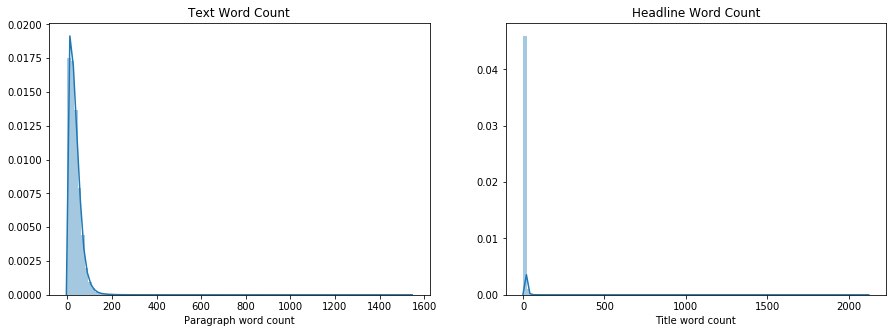

In [134]:
# Generally, what's the average word count in our headline and paragraph text? 

fig, axes = plt.subplots(1,2, figsize = (15,5)) 
sns.distplot(wordcount_intext, bins=100, ax=axes[0], axlabel = 'Paragraph word count').set_title('Text Word Count')
sns.distplot(wordcount_inheadline, bins=100, ax=axes[1], axlabel = 'Title word count').set_title('Headline Word Count')
# so it looks like title word count is muuuuch lower 

In [139]:
# rough statistics 
print('mean count of words in paragraphs: ' + str(np.nanmean(wordcount_intext)))
print('standard deviation of words in paragraphs: '+str(np.nanstd(wordcount_intext)))

mean count of words in paragraphs: 33.98637918991645
standard deviation of words in paragraphs: 27.23508579516612


In [140]:
# rough statistics 
print('mean count of words in headlines: ' + str(np.nanmean(wordcount_inheadline)))
print('standard deviation of words in headliness: '+str(np.nanstd(wordcount_inheadline)))

mean count of words in headlines: 7.112406283045566
standard deviation of words in headliness: 5.661153457812979


Text(0.5, 1.0, 'Cumulative Freq for Word Count in Text')

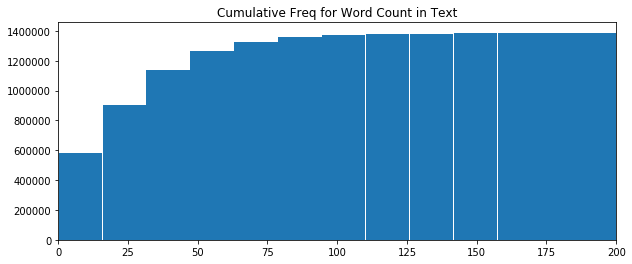

In [143]:
# cumulative distribution for better understanding of where we can cut off: 
from scipy import stats
wordcount_freq = stats.cumfreq(wordcount_intext, numbins=100)
x = wordcount_freq.lowerlimit + np.linspace(0, wordcount_freq.binsize*wordcount_freq.cumcount.size, 
                                            wordcount_freq.cumcount.size)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x, wordcount_freq.cumcount, width = wordcount_freq.binsize)
ax1.set_xlim([0, 200])
ax1.set_title('Cumulative Freq for Word Count in Text')
# looks like if we shorten down to just 200 words in text, we'll still get majority 

Text(0.5, 1.0, 'Cumulative Freq for Word Count in Headline')

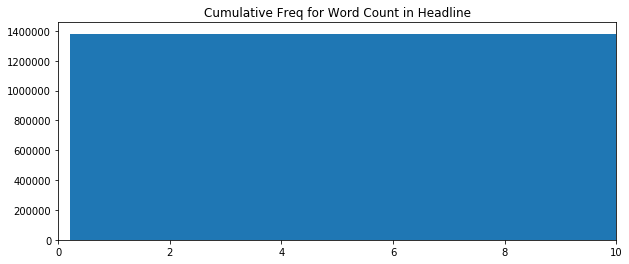

In [145]:
wordcount_summary_freq = stats.cumfreq(wordcount_inheadline, numbins=100)
x = wordcount_summary_freq.lowerlimit + np.linspace(0, wordcount_summary_freq.binsize*wordcount_summary_freq.cumcount.size, 
                                            wordcount_summary_freq.cumcount.size)
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,1,1)
ax1.bar(x, wordcount_summary_freq.cumcount, width = wordcount_summary_freq.binsize)
ax1.set_xlim([0,10])
ax1.set_title('Cumulative Freq for Word Count in Headline')
# Looks like if we shorten down to just 10 words in headline, we'll still be fine for summary 


